In [1]:
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

#### Equation as described in Donghia+14:

$m = \frac{e^{2y}}{X}([\frac{M_B}{M_D} \frac{2y+3a_b/R_d}{(2y+a_b/R_d)^3}]$

$+ [\frac{M_H}{M_D} \frac{2y+3a_h/R_d}{(2y+a_h/R_d)^3}]$

$+ \frac{y^2}{2}(3I_0 K_0 - 3I_0 K_1 + I_1 K_2 - I_2 K_1)$

$+ 4y(I_0 K_0 - I_1 K_1))$
 
Variables:

$y = R/R_d$ (how far out in the disc the arms are)

$M_D$ = disc mass (obtainable from Mendel+14)

$M_B$ = bulge mass (obtainable from Mendel+14)

$M_H$ = halo mass 

$R_d$ = disc scale length (obtainable from Simard+11)

$a_b$ = bulge scale length (obtainable from Simard+11)

$a_h$ = halo scale length

$X$ = amplification parameter, strongest when X=1.5 (Athanassoula 84, Fuchs 01)

$I,K$ = modified Bessel functions, of $y$ (presumably?)

In [4]:
import astropy.units as u
import astropy.constants as const
from scipy.special import kn as K, iv as I

def m_equation(R,R_d,a_b,a_h,M_D,M_B,M_H,X=1.5):
    
    y = (R/(2*R_d)).value
    a = np.exp(2*y)/X
    b = (M_B/M_D) * ((2*y + (3*a_b/R_d)) / (2*y + (a_b/R_d))**3)
    c = (M_H/M_D) * ((2*y + (3*a_h/R_d)) / (2*y + (a_h/R_d))**3)
    d = (y**2/2) * (3*(I(1,y)*K(0,y)) - 3*(I(0,y)*K(1,y)) + (I(1,y)*K(2,y)) - (I(2,y)*K(1,y)))
    e = (4*y) * (I(0,y)*K(0,y) - (I(1,y)*K(1,y)))
    m = a*(b + c + d + e)
    return m

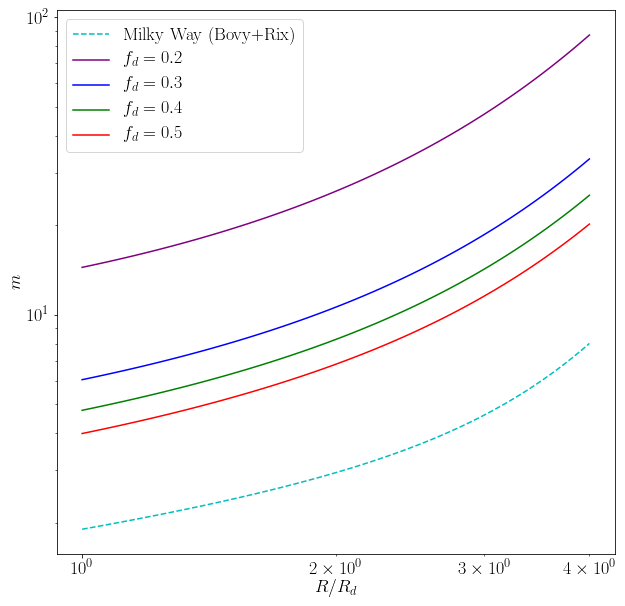

In [299]:
M_h = 9.5e11 * u.Msun
a_h = 29.6 * u.kpc

M_b = 4e9 * u.Msun
a_b = 0.6 * u.kpc

M_d = 5.9e10 * u.Msun
R_d = 2.15 * u.kpc

R = np.linspace(1,4,100) * R_d

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

m = m_equation(R,R_d,a_b,a_h,M_d,M_b,M_h)

_ = ax.plot(R/R_d,m,color='c',linestyle='dashed',
            label='Milky Way (Bovy+Rix)')

# --- Model galaxies ---
colors = ('purple','b','g','r')
L = np.linspace(3.3,2.75,4) * u.kpc

for f_d, r, color in zip(np.linspace(0.2,0.5,4),L,colors):
    r_22 = 2.2 * R_d
    M_h_22 = M_halo * r_22**2/(r_22 + a_h)**2
    M_disc = f_d * M_h_22
    M_halo = (1-f_d) * M_h
    m = m_equation(R,l,0*u.kpc,a_h,M_disc,0*u.Msun,M_halo)
    _ = ax.plot(R/R_d,m,color=color,
                label='$f_d={}$'.format(f_d))

    
_ = ax.set_xlabel('$R/R_d$')
_ = ax.set_ylabel('$m$')
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.legend()

#_ = plt.scatter([1,2,3,4],[1.9,2.6,4.4,8],
                #color='k',marker='+')

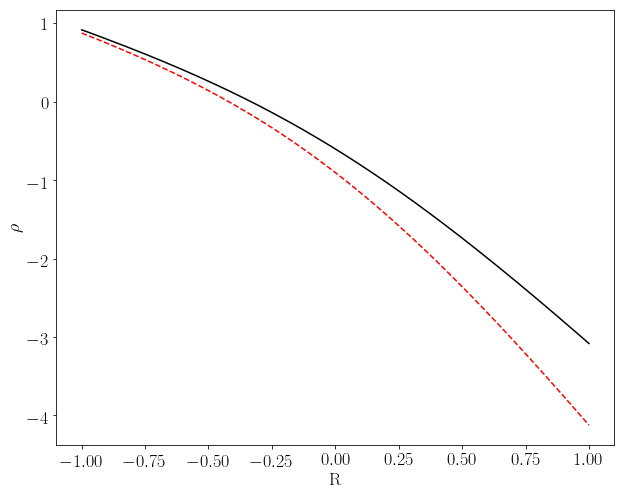

In [67]:
# NFW vs. Hernquist

def NFW(r,r_s,rho0):
    return rho0/((r/r_s)*(1+r/r_s)**2)

def Hernquist(r,a,rho0):
    return rho0 * (a/r) * 1/(r+a)**3

r = np.linspace(0.1,10,1000)
rho_nfw = NFW(r,1,1)
rho_hernquist = Hernquist(r,1,1)
_ = plt.plot(np.log10(r),np.log10(rho_nfw),color='k')
_ = plt.plot(np.log10(r),np.log10(rho_hernquist),
             color='r',linestyle='dashed')
_ = plt.xlabel('R')
_ = plt.ylabel(r'$\rho$')

### 'Model' galaxy

Consider a fake galaxy with some roughly ~median values: how does it do?

In [538]:
import astropy.constants as const
import astropy.units as u
from scipy.special import gamma

class DuttonHalo():
    def __init__(self,mass,alpha=0.5,beta=0,logx0=10.4,logy0=1.61,gamma=1):
        self.alpha = alpha
        self.beta = beta
        self.x0 = 10**logx0 * u.Msun
        self.y0 = 10**logy0 
        self.gamma = gamma
        self.mass = mass
        
        H0 = 70 * u.km/u.s/u.Mpc
        rho_crit = (3 * H0**2) / (8*math.pi*const.G)
        self.rho_crit = rho_crit.to(u.kg/u.m**3)
        
    def halo_mass(self):
        a = self.y0 * (self.mass/self.x0)**self.alpha
        b = 1/2 + 1/2*((self.mass/self.x0)**self.gamma)
        c = (self.beta-self.alpha)/self.gamma
        y = a * b**c
        return y * self.mass
    
    def R_halo(self):
        M_200 = self.halo_mass()
        c_200 = 0.905 - 0.101*np.log10(M_200/(10**12 * u.Msun))
        R_200 = (3 * M_200/(4*np.pi*200*self.rho_crit))**(1/3)
        R_s = R_200 / c
        return R_s.to(u.kpc)

    
class DiscTotal():
    def __init__(self,M_HI,M_disc,r_e,n=1):
        self.M_HI = M_HI
        self.M_disc = M_disc
        self.r_e = r_e
        #Me = M_disc/((r_e**2)*(2*math.pi*n)*(math.exp(1.678)/(1.678**(2*n)))*gamma(2*n))
        self.M_0 = M_disc/r_e
        #self.Me = Me
        R_HI = 10**((np.log10(self.M_HI.value)-7.2)/1.87)
        self.r_e_HI = 0.2 * R_HI * u.kpc
        self.M_HI0 = M_HI/self.r_e_HI
        self.n = n
        
    def rho_stars(self,r):
        return self.M_0 * np.exp((-r/self.r_e))
        #return self.Me * np.exp(-1.678*((r/self.r_e)**(1/self.n)-1))
    
    def rho_gas(self,r):
        return self.M_HI0 * np.exp(-r/self.r_e_HI)
        
    def total_mass(self):
        return self.M_HI + self.M_disc
    
    def R_eff(self):
        r_test = np.linspace(0,100,1000) * u.kpc
        rho_disc = self.rho_stars(r_test)
        rho_hi = self.rho_gas(r_test)
        rho_total = rho_disc.value + rho_hi.value
        rho_fraction = rho_total/rho_total[0]
        i = self.find_nearest(rho_fraction,1/math.e)
        return r_test[i]
        
    def find_nearest(self,array,value):
        i = np.abs(array-value).argmin()
        return i

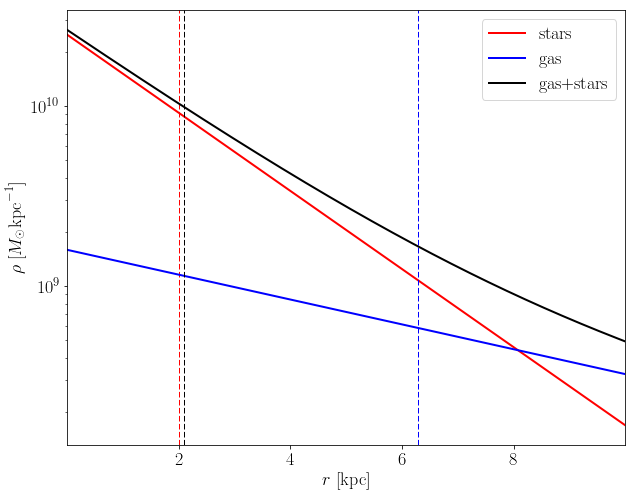

In [555]:
# --- Effect of adding in HI to the disc mass: ---

M_HI =  1e10 * u.Msun
M_disc = 5e10 * u.Msun

r_e = 2*u.kpc

mass_profile = DiscTotal(M_HI,M_disc,r_e)
r = np.linspace(0,10,1000) * u.kpc

rho_stars = mass_profile.rho_stars(r)
rho_gas = mass_profile.rho_gas(r)
rho_total = rho_stars.value + rho_gas.value

rhos = [rho_stars,rho_gas,rho_total]
R_effs = [mass_profile.r_e.value,mass_profile.r_e_HI.value,
          mass_profile.R_eff().value]

labels = ('stars','gas','gas+stars')
colors = 'rbk'

for rho, r_eff, label, color in zip(rhos,R_effs,labels,colors):
    plt.plot(r,rho,label=label,color=color,lw=2)
    
    _ = plt.axvline(r_eff,color=color,
                    linestyle='dashed',lw=1)

#_ = plt.yscale('log')
_ = plt.xlabel('$r$ [kpc]')
_ = plt.ylabel(r'$\rho$ [$M_\odot \mathrm{kpc}^{-1}$]')
_ = plt.legend()
_ = plt.yscale('log')

_ = plt.xlim(0,10)

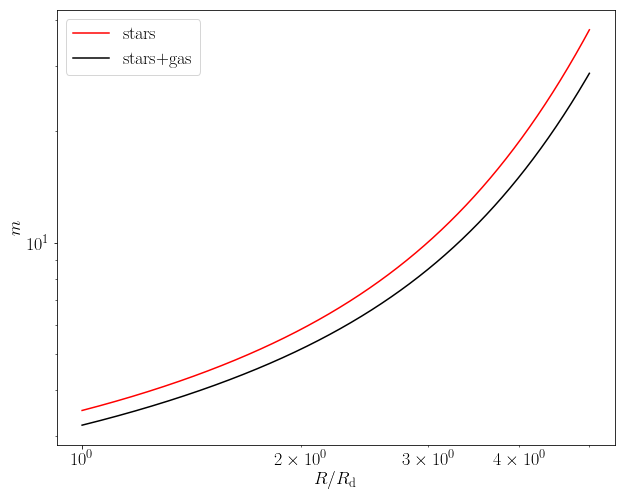

In [569]:
M_d = 5e10 * u.Msun
R_d = 5 * u.kpc

M_b = 5e9 * u.Msun
a_b = 1 * u.kpc

M_h = 9.5e11 * u.Msun
a_h = 29.6 * u.kpc

M_HI = 1e10 * u.Msun

r = np.linspace(1,5,1000) * R_d
m_stars = m_equation(r,R_d,a_b,a_h,M_d,M_b,M_h,X=1.5)
_ = plt.plot(r/R_d,m_stars,color='r',label='stars')

mass_profile = DiscTotal(M_HI,M_d,R_d)
R_d_modified = mass_profile.R_eff()
M_d_modified = mass_profile.total_mass()

m_stars_gas = m_equation(r,R_d_modified,a_b,a_h,
                         M_d_modified,M_b,M_h,X=1.5)
_ = plt.plot(r/R_d,m_stars_gas,color='k',label='stars+gas')

_ = plt.legend()
_ = plt.xlabel('$R/R_\mathrm{d}$')
_ = plt.ylabel('$m$')
_ = plt.xscale('log')
_ = plt.yscale('log')

#### Now: sample selection #####

In [605]:
#gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

p_spiral = (gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
          * gz2_data['t02_edgeon_a05_no_debiased_rh']
          * gz2_data['t04_spiral_a08_spiral_debiased_rh'])

N_spiral = (gz2_data['t04_spiral_a08_spiral_count'] - 
            gz2_data['t11_arms_number_a37_cant_tell_count'])

p_bar = gz2_data['t03_bar_a06_bar_debiased_rh']

m_columns = ('t11_arms_number_a31_1_debiased_rh',
             't11_arms_number_a32_2_debiased_rh',
             't11_arms_number_a33_3_debiased_rh',
             't11_arms_number_a34_4_debiased_rh',
             't11_arms_number_a36_more_than_4_debiased_rh')

m_array = np.array([gz2_data[c] for c in m_columns]).T
m_absolute = np.argmax(m_array,axis=1) + 1
m_avg = np.zeros(len(m_array))
for c in range(5):
    m_avg += (c+1) * m_array[:,c]
m_avg /= np.sum(m_array,axis=1)
m_avg[np.isfinite(m_avg) == False] = 0

morph_data = Table()
morph_data['p_spiral'] = p_spiral
morph_data['N_spiral'] = N_spiral
morph_data['p_bar'] = p_bar
morph_data['m_avg'] = m_avg
morph_data['m'] = m_absolute
morph_data.write('fits/morph_data.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [606]:
# Bulge + disc data
#simard_data = Table.read('../fits/Simard+Mendel/simard_matched.fits')
#mendel_data = Table.read('../sparcfire2/fits/mendel_matched.fits')

# use a correction of 1/1.5 downwards to get NIR (ie. mass) sizes (Vulcani+14).
R_disc = simard_data['Rd'] / 1.5
R_disc_error = simard_data['e_Rd'] / 1.5

R_bulge = simard_data['Re'] / 1.5
R_bulge_error = simard_data['e_Re'] / 1.5 

M_bulge = mendel_data['logMb']
M_bulge_error = mendel_data['b_logMb']

M_disc = mendel_data['logMd']
M_disc_error = mendel_data['b_logMd']

M_total = np.log10(10**M_disc + 10**M_bulge)

mass_data = Table()
mass_data['M_bulge'] = M_bulge
mass_data['M_disc'] = M_disc
mass_data['R_bulge'] = R_bulge
mass_data['R_disc'] = R_disc
mass_data['M_bulge_error'] = M_bulge_error
mass_data['M_disc_error'] = M_disc_error
mass_data['R_bulge_error'] = R_bulge_error
mass_data['R_disc_error'] = R_disc_error
mass_data['M_total'] = M_total
mass_data.write('fits/mass_data.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
INFO:astropy:Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table.


INFO: Upgrading Table to masked Table. Use Table.filled() to convert to unmasked table. [astropy.table.table]


In [636]:
mendel_matched.colnames

['mask',
 'objID',
 'z',
 'logM',
 'b_logM',
 'b_logm_lc',
 'zmin',
 'zmax',
 'Type',
 'logMt',
 'b_logMt',
 'b_logmt_lc',
 'logMb',
 'b_logMb',
 'b_logmb_lc',
 'logMd',
 'b_logMd',
 'b_logmd_lc',
 'PpS',
 'dBD',
 '_RA',
 '_DE',
 'dr7objid',
 'bulge+disc']